In [4]:
import numpy as np

import codecs
import statsmodels.tsa.stattools as sm
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.tsa.arima_model as ar
import statsmodels.graphics.gofplots as splots
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
from scipy.optimize import fsolve
from scipy.stats import norm

def multiread(start_date,end_date,subsample=1):
    res = np.zeros(0)
    for n in range(int ((end_date - start_date).days)):
        ddate = start_date + datetime.timedelta(n)
        res = np.append(res,sirtaread(ddate.day,ddate.month,ddate.year,subsample))
    return res
def multitest(start_date,end_date):
    res = np.zeros(0)
    for n in range(int ((end_date - start_date).days)):
        ddate = start_date + datetime.timedelta(n)
        sirtatest(ddate.day,ddate.month,ddate.year)
    return res
     
    
def datetimestr_sirta(datestr):
    d = datetime.datetime.strptime(datestr.decode("utf-8"),'%Y-%m-%dT%H:%M:%SZ')
    d0 = datetime.datetime(year=2000,month=1,day=1,hour = 0)
    return ((d-d0).total_seconds())


    
def sirtatest(day,month,year):
    # generate file name
    filename = 'meteoz2_1a_1min_v03_'+str(year)
    if(month<10):
        filename = filename + '0'
    filename = filename + str(month)
    if(day<10):
        filename = filename + '0'
    filename = filename + str(day)+'_000000_1440.asc'
    #print(filename)
    try:
        wdata = np.loadtxt('weather_data/'+filename,usecols=[1])
        if (len(wdata)<1440):
            print (filename,len(wdata))
    except IOError:
        print("File not found"+filename)
    
    
def sirtaread(day,month,year,subsample=1):
    # generate file name
    d0 = datetime.datetime(year=2000,month=1,day=1,hour = 0)
    d = datetime.datetime(year,month,day,hour=0)
    day_start =  ((d-d0).total_seconds())
    filename = 'meteoz2_1a_1min_v03_'+str(year)
    if(month<10):
        filename = filename + '0'
    filename = filename + str(month)
    if(day<10):
        filename = filename + '0'
    filename = filename + str(day)+'_000000_1440.asc'
    filecp = codecs.open('weather_data/'+filename, encoding = 'utf-8',errors="ignore")
    res = np.loadtxt(filecp,usecols=[0,1],converters={0:datetimestr_sirta})
    if res.shape[0]<1440: # missing data
        print("Missing data in "+filename + ": " + str(res.shape[0]))
        wdata = np.ones(1440)*np.mean(res[:,1]) # Replacing with average
        ind = (res[:,0]-day_start)/60
        wdata[ind.astype(int)] = res[:,1]
    else:
        wdata = res[:,1]
    if(subsample>1):
        ndata = np.zeros(int(len(wdata)/subsample))
        for i in range(subsample):
            ndata = ndata + wdata[i::subsample]
        wdata = ndata/subsample
    return wdata



In [5]:
# Read the time series from file
sdate = datetime.date(2010,1,1)
edate = datetime.date(2012,12,31)
wdata60 = multiread(sdate,edate,60)
wdata = multiread(sdate,edate,1)

Missing data in meteoz2_1a_1min_v03_20101007_000000_1440.asc: 1381
Missing data in meteoz2_1a_1min_v03_20120910_000000_1440.asc: 1438
Missing data in meteoz2_1a_1min_v03_20120914_000000_1440.asc: 1381
Missing data in meteoz2_1a_1min_v03_20101007_000000_1440.asc: 1381
Missing data in meteoz2_1a_1min_v03_20120910_000000_1440.asc: 1438
Missing data in meteoz2_1a_1min_v03_20120914_000000_1440.asc: 1381


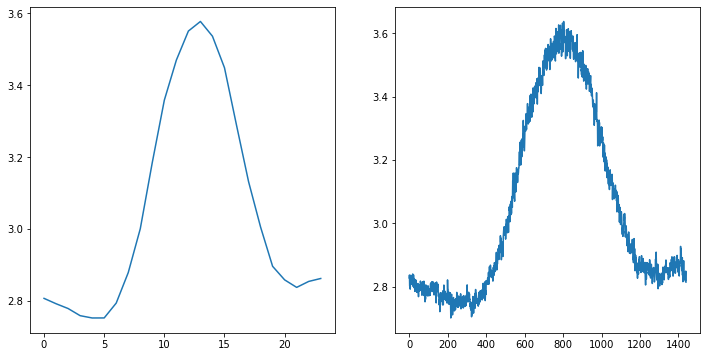

In [26]:
#Remove seasonality
wdata60d = np.array(wdata60)
dailymean = np.zeros(24)
for i in range(24): 
    dailymean[i] = np.mean(wdata60[i::24])
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(24),dailymean)
for i in range(int(len(wdata60)/24)):
    wdata60d[24*i:(i+1)*24] /=dailymean
    
wdatad = np.array(wdata)
dailymean1 = np.zeros(24*60)
for i in range(24*60): 
    dailymean1[i] = np.mean(wdata[i::24*60])
plt.subplot(1,2,2)
plt.plot(range(24*60),dailymean1)
for i in range(int(len(wdata)/24/60)):
    wdatad[24*60*i:(i+1)*24*60] /=dailymean1

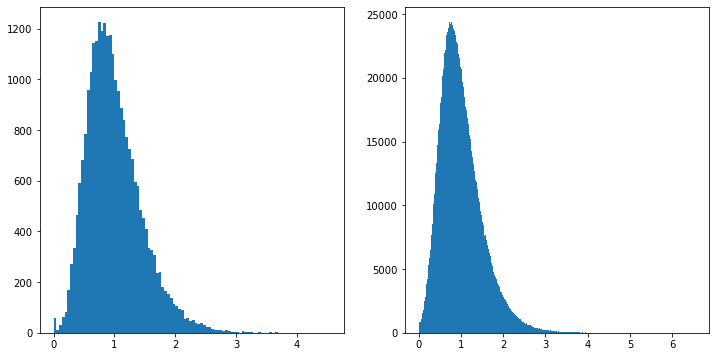

In [27]:
# plot the deseasonalizes series
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(wdata60d,100);
plt.subplot(1,2,2)
plt.hist(wdatad,400);

# Probabilistic prediction using a parametric ARMA model

/Users/petertankov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/petertankov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


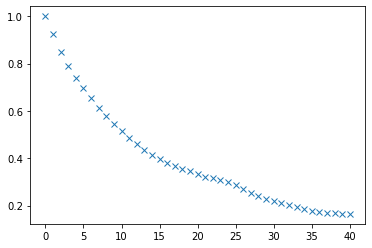

In [8]:
# Autocorrelation
plt.plot(sm.acf(wdata60d),'x')

In [9]:
# Dickey-Fuller test: unit root rejected
sm.adfuller(wdata60d)

(-15.497249884358624,
 2.441464665467881e-28,
 48,
 26231,
 {'1%': -3.430599321034093,
  '5%': -2.8616501925763513,
  '10%': -2.566828652246847},
 -17373.538659031918)

/Users/petertankov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1016: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


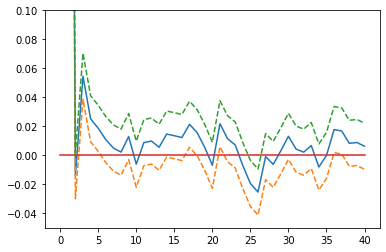

In [10]:
# Partial autocorrelation: suggests an AR(4) model
(pa,conf ) = sm.pacf(wdata60d,alpha=0.01)
plt.plot(range(41),pa,range(41),conf[:,0],'--',range(41),conf[:,1],'--')
plt.ylim([-0.05,0.1])
plt.plot((0,40),(0,0))

In [11]:
ar_model = ar.ARMA(wdata60d,(4,0))
ar_fit = ar_model.fit()

/Users/petertankov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [12]:
print(ar_fit.params)
print(ar_fit.sigma2)
print(ar_fit.k_trend)

[ 1.00030955  0.93569892 -0.06351367  0.03097056  0.02523147]
0.030261405154824773
1


The AR(4) model has the form
$$
X_t = c + a_1 X_{t-1} + a_2 X_{t-2} + a_3 X_{t-3} + a_4 X_{t-4} + \varepsilon_t
$$
where $(\varepsilon_t)$ are Gaussian i.i.d. residuals with variance $\sigma^2$

Forecasting is done as follows:
\begin{align*}
\hat X_{t+1} &= c + a_1 X_{t} + a_2 X_{t-1} + a_3 X_{t-2} + a_4 X_{t-3}\\
\hat X_{t+2} &= c + a_1 \hat X_{t+1} + a_2 X_{t} + a_3 X_{t-1} + a_4 X_{t-2} \\
\dots
\end{align*}
The confidence intervals are estimated from the Gaussian quantiles:
\begin{align*}
&X_{t+1} - \hat X_{t+1} \sim N(0,\sigma^2)\\
&X_{t+2} - \hat X_{t+2} \sim N(0,\sigma^2(1+a_1^2))\\
\dots
\end{align*}

The predictive distribution is normal, and the CRPS for $F\sim N(\mu,\sigma^2)$ is given by
$$
crps(F,y) = \sigma\left(\frac{y-\mu}{\sigma}\left(2\Phi\left(\frac{y-\mu}{\sigma}\right)-1\right)+2\left(\frac{y-\mu}{\sigma}\right)-\frac{1}{\sqrt{\pi}}\right)
$$

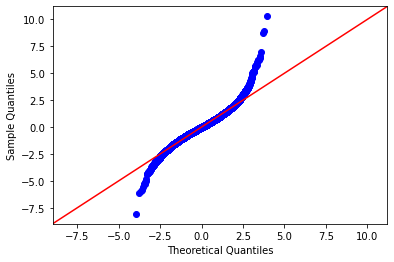

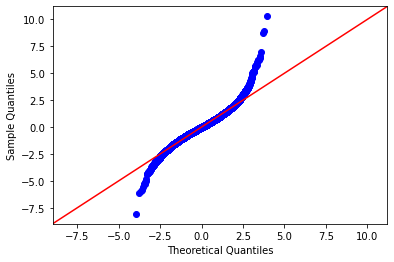

In [13]:
# QQ plot shows important deviations from Gaussian
splots.qqplot(ar_fit.resid,fit=True, line='45')

/Users/petertankov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/petertankov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


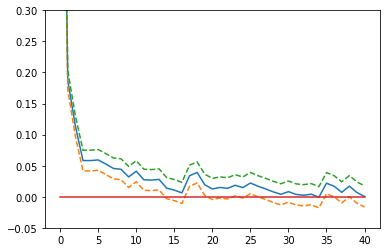

In [14]:
# Autocorrelation of squared residuals provides evidence of heteroscedascisity
(pa,conf ) = sm.acf(np.power(ar_fit.resid,2),alpha=0.01)
plt.plot(range(41),pa,range(41),conf[:,0],'--',range(41),conf[:,1],'--')
plt.ylim([-0.05,0.3])
plt.plot((0,40),(0,0))

In [15]:
def ar_pit(data,forecast,sigma):
    # probability integral transform 
    # for probabilistic prediction lag steps ahead
    F = np.zeros(0)
    F = norm.cdf((data-forecast)/sigma)
    for t in range(len(data)):
        sample = data[t] + data[t-Nprob:t] - data[t-Nprob-lag:t-lag]
        F = np.append(F,1.0*len(np.where(sample<=data[t+lag])[0])/Nprob)
    return F

def ar_crps(data,forecast,sigma):
    crps = 0
    for t in range(len(data)):
        rat = (data[t]-forecast[t])/sigma
        crps+=sigma*(rat*(2*norm.cdf(rat)-1)+2*norm.pdf(rat)-1./np.sqrt(np.pi))
    return crps/len(data)



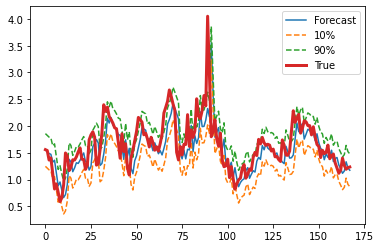

In [16]:
# 2h-ahead prediction with AR(4) model
end_date = 26280
start_date = end_date-7*24
xcoord = range(end_date-start_date)
forecast = np.zeros(end_date-start_date)
for i in range(start_date,end_date):
    forecast[i-start_date] = ar_fit.predict(i-1,i,dynamic=True)[1]
conf01 = norm.ppf(0.9)*np.sqrt(ar_fit.sigma2*(1+ar_fit.params[1]*ar_fit.params[1]))   
plt.plot(xcoord,forecast,label="Forecast")
plt.plot(xcoord,forecast-conf01,'--',label="10%")
plt.plot(xcoord,forecast+conf01,'--',label="90%")
plt.plot(xcoord,wdata60d[start_date:end_date],linewidth=3,label="True")
plt.legend()

In [17]:
# Computing the forecast for 365 days
end_date = 26280
start_date = end_date-365*24
xcoord = range(end_date-start_date)
forecast = np.zeros(end_date-start_date)
for i in range(start_date,end_date):
    forecast[i-start_date] = ar_fit.predict(i-1,i,dynamic=True)[1]
data = wdata60d[start_date:end_date]

Width of confidence interval: 0.6106226641025404
CRPS: 0.13112053308177096


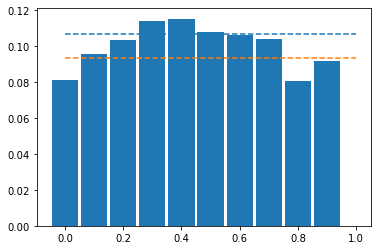

In [18]:
# Width of confidence interval, CRPS and the PIT plot
sigma = np.sqrt(ar_fit.sigma2*(1+ar_fit.params[1]*ar_fit.params[1]))
conf01 = norm.ppf(0.9)*sigma
print("Width of confidence interval: "+str(2*conf01))
print("CRPS: "+str(ar_crps(data,forecast,sigma)))
PIT = norm.cdf((data-forecast)/sigma)
(val, pos) = np.histogram(PIT,10)
plt.bar(pos[0:-1],1.0*val/365/24,width=0.09)
std2 = 2*np.sqrt(0.1/24/365)
plt.plot([0,1],[0.1+std2,0.1+std2],'--',[0,1],[0.1-std2,0.1-std2],'--'  )

# Probabilistic prediction using nonparametric persistence forecast

Point prediction: $\hat X_{t+h} = X_t$ 

Probabilistic prediction: empirical distribution function of 
$$
(X_{t-d}-X_{t-d-h}+X_t)_{d=0,\dots,D-1}
$$

The empirical distribution function of a sample of $n$ elements is defined by 
$$
\hat F_n(x) = \frac{1}{n}\sum_{i=1}^n \mathbf 1_{x_i \leq x}
$$
\begin{align*}
crps(\hat F_n,y) &= \int_{-\infty}^\infty \left\{\hat F_n(x) - \mathbf 1_{y\leq x}\right\}^2 dx\\
& =\int_{-\infty}^y \hat F_n(x)^2 dx + \int_{y}^\infty \left\{\hat F_n(x) - 1\right\}^2 dx\\
    & = \frac{2}{n}\sum_{k=1}^n (x_{(k)}-y)\left\{\mathbf 1_{x_{(k)}>y} - \frac{k-\frac{1}{2}}{n}\right\}
\end{align*}

In [19]:
def pf_point(data,start,end,lag):
    # point prediction
    return data[start-lag:end-lag]

def pf_conf(data,start,end,lag,Nprob,alpha):
    # confidence intervals at the level alpha 
    # for prediction lag steps ahead
    res = np.zeros((end-start,2))
    for t in range(start-lag,end-lag):
        sample = data[t] + data[t-Nprob:t] - data[t-Nprob-lag:t-lag]
        res[t-start+lag,0] = np.percentile(sample,alpha*100)
        res[t-start+lag,1] = np.percentile(sample,(1.0-alpha)*100)
    return res
    
def pf_pit(data,start,end,lag,Nprob):
    # probability integral transform 
    # for probabilistic prediction lag steps ahead
    F = np.zeros(0)
    for t in range(start-lag,end-lag):
        sample = data[t] + data[t-Nprob:t] - data[t-Nprob-lag:t-lag]
        F = np.append(F,1.0*len(np.where(sample<=data[t+lag])[0])/Nprob)
    return F

def pf_crps(data,start,end,lag,Nprob):
    cprs = 0
    for t in range(start-lag,end-lag):
        sample = np.sort(data[t]-data[t+lag] + data[t-Nprob:t]
                         - data[t-Nprob-lag:t-lag])
        cprs = cprs+2.0/Nprob*(np.sum(sample*(sample>0))-
                              np.sum(sample*np.linspace(-0.5,Nprob-0.5,Nprob)/Nprob))
    return cprs/(end-start)
        
    
    

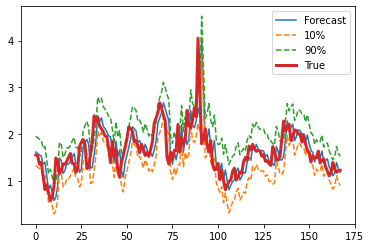

In [20]:
# Confidence interval for 2h-ahead prediction
end_date = 26280
start_date = end_date-7*24
xcoord = range(end_date-start_date)
conf01 = pf_conf(wdata60d,start_date,end_date,2,100,0.1)
plt.plot(xcoord,pf_point(wdata60d,start_date,end_date,2),label="Forecast")
plt.plot(xcoord,conf01[:,0],'--',label="10%")
plt.plot(xcoord,conf01[:,1],'--',label="90%")
plt.plot(xcoord,wdata60d[start_date:end_date],linewidth=3,label="True")
plt.legend()

In [21]:
# Average width of the confidence interval and CRPS
end_date = 26280
start_date = end_date-365*24
conf01 = pf_conf(wdata60d,start_date,end_date,2,100,0.1)
print("Width of confidence interval: "+str(np.mean(conf01[:,1]-conf01[:,0])))
print("CRPS: "+str(pf_crps(wdata60d,start_date,end_date,2,100)))

Width of confidence interval: 0.5819880322030417
CRPS: 0.1364559118897488


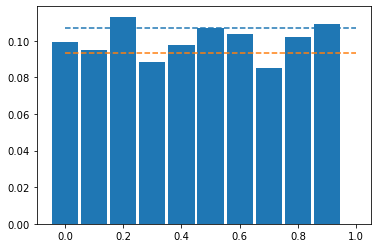

In [22]:
# The PIT transform
end_date = 26280
start_date = end_date-365*24
PIT = pf_pit(wdata60d,start_date,end_date,2,100)
(val, pos) = np.histogram(PIT,10)
plt.bar(pos[0:-1],1.0*val/365/24,width=0.09)
std2 = 2*np.sqrt(0.1/24/365)
plt.plot([0,1],[0.1+std2,0.1+std2],'--',[0,1],[0.1-std2,0.1-std2],'--'  )

## Quantile regression

E[Q90-Q10]: 0.6122097653523593


<BarContainer object of 10 artists>

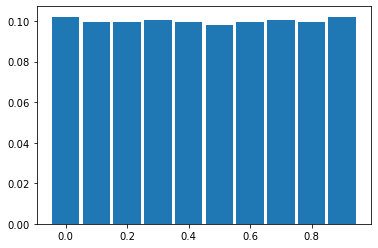

In [23]:
ed = 26280
sd = ed-30*24
forecast = 2
maxlag = 4
resp = wdata60d[sd+3+forecast:ed] # Response variables
#expl = np.transpose(np.vstack((np.ones(len(resp)),wdata60d[:-5],wdata60d[1:-4],
#                              wdata60d[2:-3],wdata60d[3:-2],wdata60d[3:-2]*wdata60d[3:-2])))
#                              (wdata60d[3:-2]-wdata60d[2:-3])*(wdata60d[3:-2]-wdata60d[2:-3]))))
expl = np.transpose(np.vstack((np.ones(len(resp)),wdata60d[sd:ed-3-forecast],
                               wdata60d[sd+3:ed-forecast],
                              (wdata60d[sd+3:ed-forecast]-wdata60d[sd+2:ed-1-forecast])
                               *(wdata60d[sd+3:ed-forecast]-wdata60d[sd+2:ed-1-forecast]))))

mod = QuantReg(resp,expl)
nquant = 10
quant = np.linspace(1./nquant,1.-1./nquant,nquant-1)
pquant = np.zeros((len(resp),len(quant)))
for i in range(nquant-1):
    res = mod.fit(q=quant[i])
    pquant[:,i] = np.dot(expl,res.params)
print('E[Q90-Q10]:', np.mean(pquant[:,-1]-pquant[:,0]))    
nhits = np.zeros(nquant-1)
for i in range(nquant-1):
    nhits[i] = np.sum(resp<pquant[:,i])
pit = np.zeros(nquant)
nhits = nhits/len(resp)
pit[0] = nhits[0]
pit[1:-1] = np.diff(nhits)
pit[-1] = 1.-nhits[-1]
plt.bar(np.linspace(0.0,1.-1./nquant,nquant),pit,width=0.09)



[1.03290022e-11 8.69631161e-11 3.89072432e-10 5.97101956e-10
 8.14342358e-10 1.65830818e-09 1.86369043e-10 5.59526268e-10
 6.20979760e-10 1.66484751e-09 1.79699722e-09 3.85144717e-09
 7.86889543e-09 1.55433177e-08 1.48471214e-08 8.01655627e-09
 1.48384196e-08 2.08442894e-08 4.21453054e-08 3.69356313e-08
 6.24681280e-08 1.19879405e-07 2.24910750e-07 2.74208822e-07
 2.24772088e-07 4.04746506e-07 7.03866327e-07 8.40036227e-07
 1.43513645e-06 2.41137807e-06 3.95484226e-06 5.81471179e-06
 8.46026531e-06 9.38000517e-06 1.31788489e-05 1.45374949e-05
 2.21137758e-05 3.37923796e-05 4.46755504e-05 6.57462231e-05]


/Users/petertankov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/petertankov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/petertankov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:531: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  warnings.warn("The default value of lags is changing.  After 0.12, "
/Users/petertankov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: 

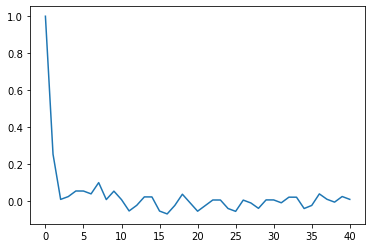

In [24]:
hits = resp<pquant[:,0]
plt.plot(sm.acf(hits))
lbvalue, pvalue = acorr_ljungbox(hits)
print(pvalue)

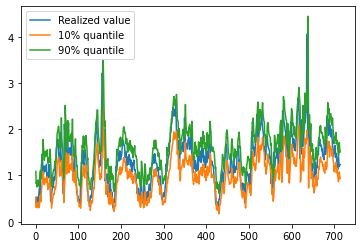

In [25]:
xcoord = range(len(resp))
plt.plot(xcoord,resp,label="Realized value")
plt.plot(xcoord,pquant[:,0],label="10% quantile")
plt.plot(xcoord,pquant[:,8],label="90% quantile")
plt.legend()

